Natalia Brzozowska
# Laboratorium 13
## Minimalizacja

***
## Zadanie 1
## Problem komiwojażera
Wygeneruj chmurę n losowych punktów w 2D, a nastepnie zastosuj algorytm symulowanego
wyżarzania do przybliżonego rozwiazania problemu komiwojażera dla tych punktów.<br><br>
        a) Przedstaw wizualizacje otrzymanego rozwiazania dla 3 różnych wartości n oraz 3
różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema
różnymi grupami parametrów, dziewięć odseparowanych grup punktów).<br><br>
    b) Zbadaj wpływ sposobu generacji sasiedniego stanu (consecutive swap - zamiana
kolejnosci losowej pary połaczonych wierzchołków w ścieżce vs. arbitrary swap -
zamiana dwóch losowych wierzchołków w ścieżce) oraz poczatkowej wartości temperatury
na zbieżnosc procesu optymalizacji.<br><br>
    c) Przedstaw wizualizacje działania procedury minimalizujacej funkcje celu (funkcja
przekazana do metody dual annealing może modyfikować zewnatrzny stan)

***
Algorytm symulowanego wyżarzania poszukuje rozwiązania o najlepszych parametrach. Poszukiwanie odbywa się poprzez losowe testowanie przypadków, aż do znalezienia najlepszego.<br><br>
Poniżej zaimplementowałam trzy funkcje losujące punkty, posługując się odpowiednią metodą. Funkcja make_cities_jedn() tworzy n punktów należąych do rozkładu jednostajengo. Funkcja make_cities_gauss() tworzy ok. n punktów według rozkładu normalnego, przy czym punkty należą do czterech grup punktów wygenerowanych z innymi parametrami. Funkcja make_cities_nine() tworzy ok. n punktów w dziewięciu odseparownych od siebie grupach.

In [276]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [277]:
def make_cities_jedn(n):
    x=[]
    y=[]
    for i in range(n):
        x.append(random.uniform(0,n*2))
        y.append(random.uniform(0,n*2))
    
    return x,y

def make_cities_gauss(n):
    x=[]
    y=[]
    for i in range(n//4):
        x.append(random.gauss(0,1))
        y.append(random.gauss(0,1))
        
        x.append(random.gauss(5,2))
        y.append(random.gauss(5,2))
        
        x.append(random.gauss(-10,3))
        y.append(random.gauss(-10,3))
        
        x.append(random.gauss(17,7))
        y.append(random.gauss(17,7))

    return x,y

def make_cities_nine(n,arr):
    x=[]
    y=[]
    for i in range(n//9):
        for el in arr:
            x.append(random.random()+el[0])
            y.append(random.random()+el[1])
    return x,y

Poniżej zaimplementowałam funkcję realizującą algorytm symulowanego wyżarzania do uzyskania przybliżonego rozwiązania problemu komiwojażera.<br> Funkcja sim_annealing() przyjmuje jako argumenty t0 - temperaturę początkową, tmin - temperaturę, do której dążymy, a - współczynnik o który będzie zmniejszana temperatura w każdym obiegu pętli, s0 - stan początkowy (indeks punktu), kamx - maksymalną liczbę iteracji, x,y - tablice zawierające odpowiednio współrzedne x i y wylosowanych punktów, method - nazwę metody generacji sąsiedniego stanu. <br> Wewnątrz funkcji wykonuje się pętla określoną ilośś razy lub aż do uzyskania tmin. Za każdym razem losowane są dwa punkty - sąsiedzi (sposób losowania zależy od wybranej metody). Następnie tworzone są nowe tablice x i y, w których sąsiedzi (punkty) zamieniane są miejscami. Obliczana jest waga takiego ustawienia punktów i poprzedniego ustawienia. Jeżeli nowe ustawienie jest lepsze (ma mniejszą wagę), to zastępuje ono stare ustawienie. W przeciwnym przypadku, nowe ustawienie zastępuje stare, z prawdopodobieństwem opisanym przez funkcję *np.exp(-1*cost/ t)* . Następnie zmniejszana jest wartość temperatury, sprawdzane jest czy nowa temperatuje jest mniejsza bądź równa tmin i jeśli nie, to pętla wykonuje się raz jeszcze. Funkcja zwraca, odpowiednio ułożone współrzedne punktów x i y, tablicę z temperaturami, tablicę energii oraz liczbę iteracji.<br>
Waga(energia) ustawienia jest obliczana jako całkowita odległość między punktami opisanymi w tablicach.

In [278]:
def get_random(n,me):
    i = random.randint(0,n-1)
    
    while i==me:
        i = random.randint(0,n-1) 
    return i


def measure_energy(x,y):
    suma = 0
    for i in range(len(x)-1):
        a = x[i]-x[i+1]
        b = y[i]-y[i+1]
        suma +=  math.sqrt(a**2 + b**2)
   
    return suma

def add_id(idi,op,leng):
    if idi+op >= leng:
        return 0
    if idi+op<0:
        return leng-1
    else:
        return idi+op

def sim_annealing(t0, tmin, a, s0, kmax, x, y, method):
    t = t0
    s = s0 
    ts = []
    energys = []

    for k in range(kmax):
        ts.append(t)
        
        if method=='arbitrary':
            s_new = get_random(len(x),-1)
            s = get_random(len(x),s_new)
        else:
            s_new = get_random(len(x),-1)
            if random.random()<0.5 :
                s = add_id(s_new,1,len(x))
            else:
                s = add_id(s_new,-1,len(x))
                
        x_new = x.copy()
        y_new = y.copy()

        x_new[s], x_new[s_new] = x_new[s_new], x_new[s]
        y_new[s], y_new[s_new] = y_new[s_new], y_new[s]
        
        en_old = measure_energy(x, y)
        en_new = measure_energy(x_new, y_new)
        cost = en_old - en_new

        if cost>=0:
            s = s_new
            x = x_new.copy()
            y = y_new.copy()
            
            energys.append(en_new)
            
        else:
            if random.random() > np.exp(-1*cost/ t):
                s = s_new
                x = x_new.copy()
                y = y_new.copy()
                energys.append(en_new)
            else:
                energys.append(en_old)
        
        t = t-a
        
        
        if t<=tmin:
            print('Minimal Temperature reached')
            break;
        
    
    return x, y, ts, energys, k+1

def draw_graph(x,y):
    plt.figure(figsize = (6,6))
    plt.plot(x,y, 'ro')
    plt.plot(x,y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def draw_graph2(x,y):
    plt.figure(figsize = (12,6))
    plt.plot(x,y, 'ro')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x,y)
    plt.show()

a) Poniżej znajduje się funkcja zawierajaca odpowiednie wywołania innych funkcji, realizująca zadanie a). Dla każdego sposobu generowania punktów generowane są trzy zestawy punktów o różnej liczbie elementów. Nastęnie przeprowadzane jest symulowane wyżarzanie, którego wynik przedstawiają wykresy.

In [279]:
def taska(i,arr1,arr2):
    for j in range(i):
        x,y = make_cities_jedn(arr1[j])
        x1,y1,_,_,_ = sim_annealing(100000,0,1,0,100000,x,y,'arbitrary')
        e = measure_energy(x, y)
        e1 = measure_energy(x1, y1)

        print('\nRozkład jednostajny. Liczba elementów:', arr1[j])
        print('Energia przed:', e)
        draw_graph(x,y)
        print('Energia po:', e1)
        draw_graph(x1,y1)
        print('-----------')
   
    for j in range(i):
        print('\n\n')
        x,y = make_cities_gauss(arr1[j])
        x1,y1,_,_,_ = sim_annealing(100000,0,1,0,100000,x,y,'arbitrary')
        e = measure_energy(x, y)
        e1 = measure_energy(x1, y1)

        print('\nRozkład Gaussa. Liczba elementów:', arr1[j])
        print('Energia przed:', e)
        draw_graph(x,y)
        print('Energia po:', e1)
        draw_graph(x1,y1)
        print('-----------')
        
    for j in range(i):
        print('\n\n')
        x,y = make_cities_nine(arr1[j],arr2)
        x1,y1,_,_,_  = sim_annealing(100000,0,1,0,100000,x,y,'arbitrary')
        e = measure_energy(x, y)
        e1 = measure_energy(x1, y1)

        print('\nRozkład dziewięciu odseparowanych grup. Liczba elementów:', arr1[j])
        print('Energia przed:', e)
        draw_graph2(x,y)
        print('Energia po:', e1)
        draw_graph2(x1,y1)
        print('-----------')

Minimal Temperature reached

Rozkład jednostajny. Liczba elementów: 16
Energia przed: 237.08716401107836


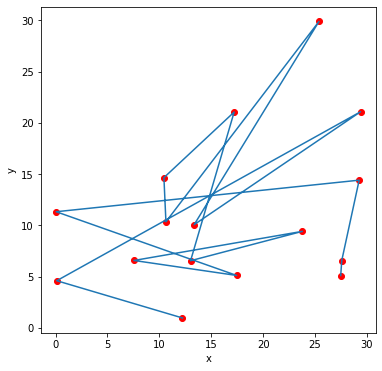

Energia po: 102.71785313913868


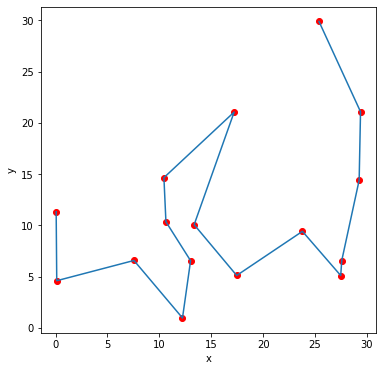

-----------
Minimal Temperature reached

Rozkład jednostajny. Liczba elementów: 48
Energia przed: 2192.3401244071183


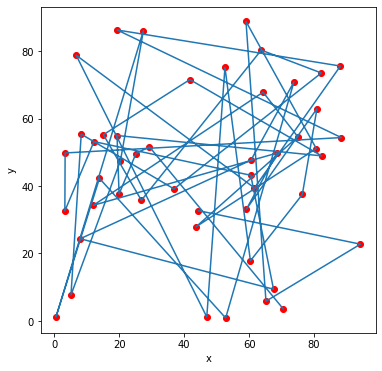

Energia po: 689.1938996907037


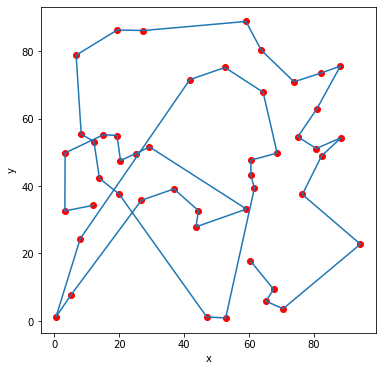

-----------
Minimal Temperature reached

Rozkład jednostajny. Liczba elementów: 128
Energia przed: 16244.954284314073


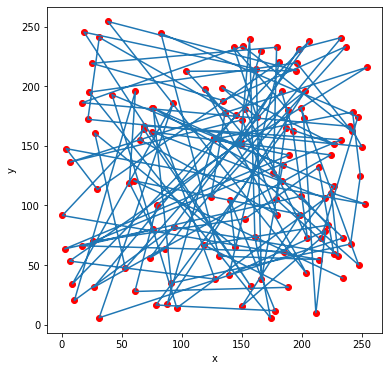

Energia po: 4289.244380241651


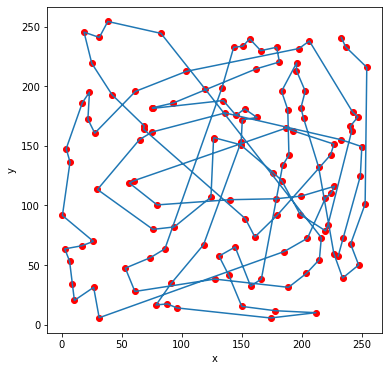

-----------



Minimal Temperature reached

Rozkład Gaussa. Liczba elementów: 16
Energia przed: 350.15466271160517


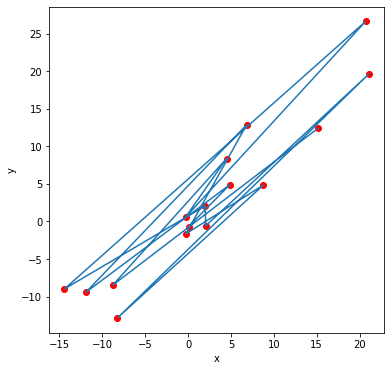

Energia po: 99.74697359413739


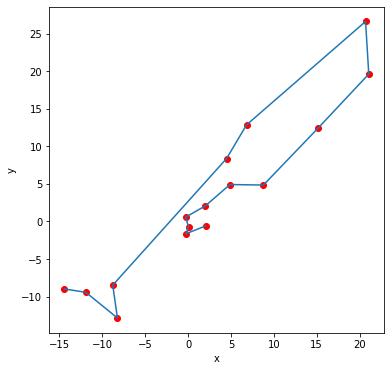

-----------



Minimal Temperature reached

Rozkład Gaussa. Liczba elementów: 48
Energia przed: 1027.1224039379038


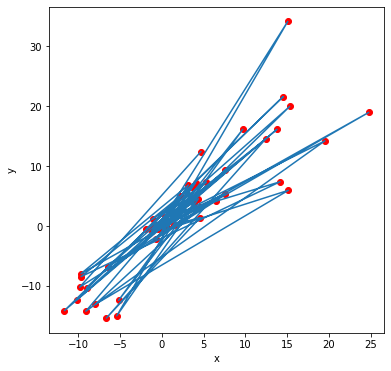

Energia po: 222.2390268489644


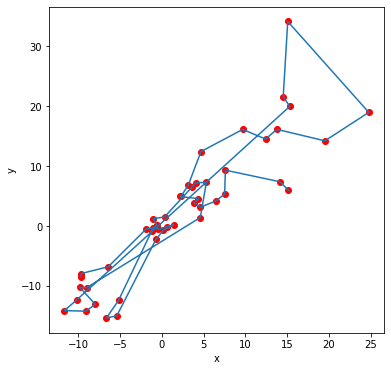

-----------



Minimal Temperature reached

Rozkład Gaussa. Liczba elementów: 128
Energia przed: 2995.1930191769507


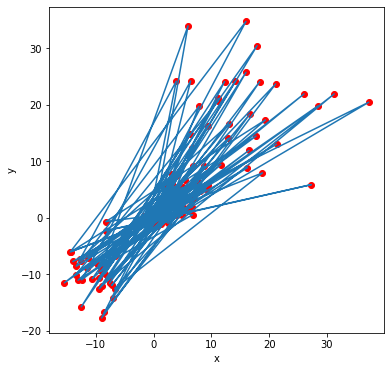

Energia po: 534.2520500131751


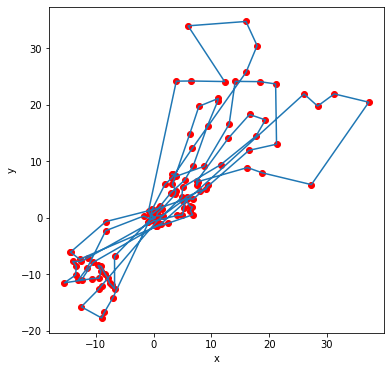

-----------



Minimal Temperature reached

Rozkład dziewięciu odseparowanych grup. Liczba elementów: 16
Energia przed: 193.20920009594434


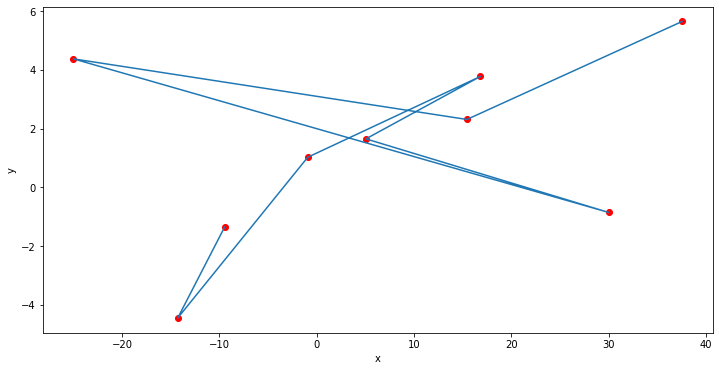

Energia po: 116.8489327478388


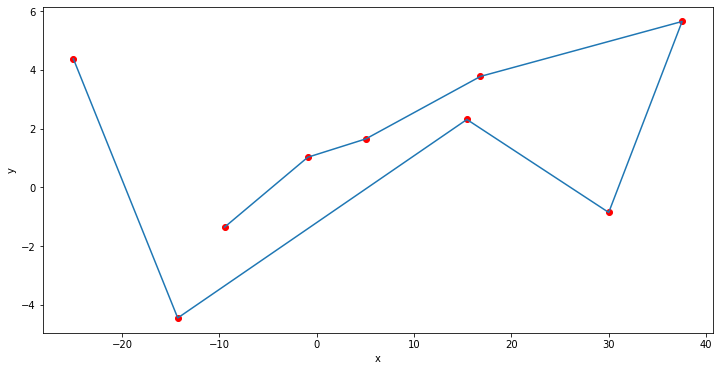

-----------



Minimal Temperature reached

Rozkład dziewięciu odseparowanych grup. Liczba elementów: 48
Energia przed: 1148.9768384293886


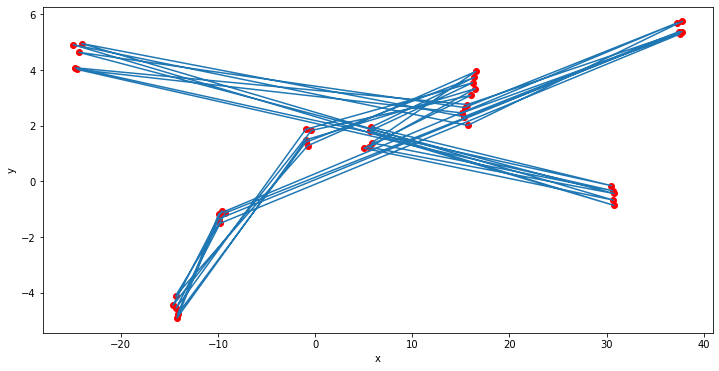

Energia po: 314.2664030288633


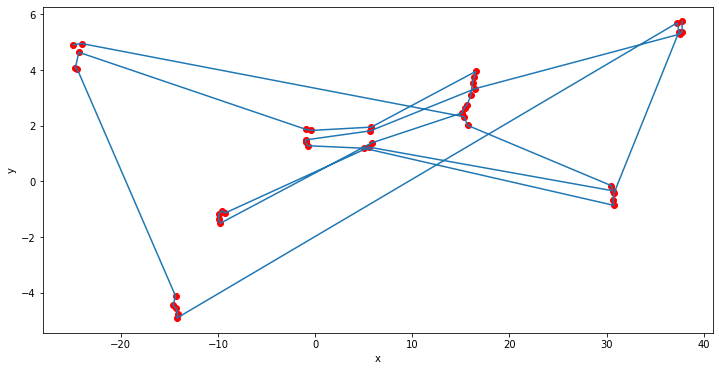

-----------



Minimal Temperature reached

Rozkład dziewięciu odseparowanych grup. Liczba elementów: 128
Energia przed: 3308.03913101277


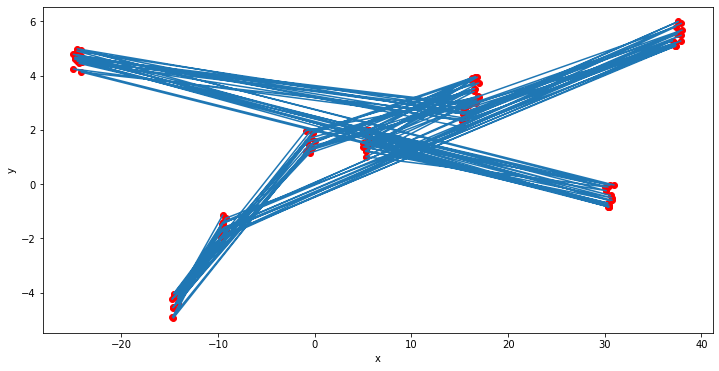

Energia po: 513.7035932372928


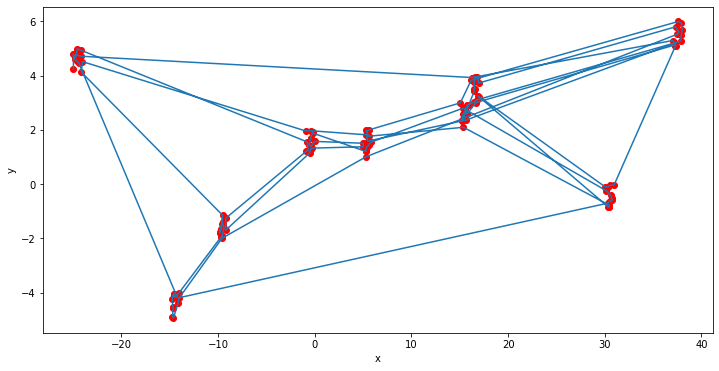

-----------


In [280]:
taska(3,[16,48,128], [[-10,-2],[-15,-5],[-1,1],[16,3], [5,1], [30,-1], [-25,4],[15,2],[37,5]])

***
### Wnioski
Jak można zauważyć na powyższych wykresach, funkcja realizująca algorytm symulowanego wyżarzania przybliżyła rozwiązanie problemu komiwojażera. Nie uzyskała ona idelanych wyników - niekóre trasy komiwojażera możnaby poprowadzić optymalniej - jednak znacząco uprościła wejściowe ścieżki w grafach.<br>
Jak można zauważyć energie ścieżek przed i po są różne - energie po wykonaniu algorytmu są mniejsze, zatem ścieżki są krótsze (dla grafów o wielu wierzchołkach nawet znacznie krótsze).<br>
Algorytm znalazł odpowiednie przybliżenia dla wszytskich sposobów generowania punktów i dla każdej ilości punktów.

***
b) Poniżej zaimplementowałam funkcję, którą posłużę się do zbadania wpływu generacji sąsiednich stanów i początkowej wartości temperatury na zbieżność procesu optymalizacji. Utworzyłam punkty wg. rozkładu jednostajnego i dla każdego sposobu generowania sąsiadów (arbitrary lub consecutive) wywołałam funkcję sim_annealing() trzy razy - dla trzech wartości początkowych temperatury.

In [286]:
def draw(x,y):
    plt.plot(x,y)
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
    plt.show()

def taskb(el):
    x1,y1 = make_cities_jedn(el)
    itera = 1000
    t0 = 10**5
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', el,'; t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Arbitrary')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)
    
    t0 = 10**4
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:',el,'; t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Arbitrary')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)
    
    t0 = 10**3
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', el,'; t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Arbitrary')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)
    
    t0 = 10**5
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'consecutive')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', el,'; t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Consecutive')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)
    
    t0 = 10**4
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'consecutive')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', el,' t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Consecutive')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)
    
    t0 = 10**3
    _,_,ts,energys,k = sim_annealing(t0,0,1,0,itera,x1,y1,'consecutive')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', el,'; t0:',t0, 'liczba iteracji:', k, 'Temperatura końcowa:', ts[len(ts)-1])
    print('Consecutive')
    print('Energia przed:',e)
    print('Energia po:', e1)
    y = np.arange(0,k,1)
    draw(y,energys)


Rozkład jednostajny. Liczba elementów: 256 ; t0: 100000 liczba iteracji: 1000 Temperatura końcowa: 99001
Arbitrary
Energia przed: 68513.60013256628
Energia po: 41366.59414709219


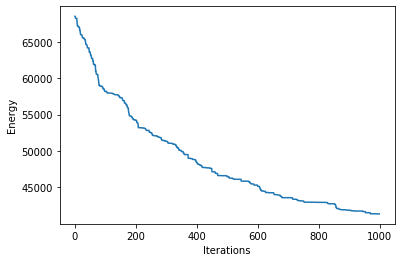


Rozkład jednostajny. Liczba elementów: 256 ; t0: 10000 liczba iteracji: 1000 Temperatura końcowa: 9001
Arbitrary
Energia przed: 68489.41794984053
Energia po: 40665.981528037955


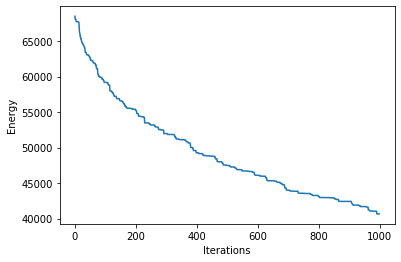

Minimal Temperature reached

Rozkład jednostajny. Liczba elementów: 256 ; t0: 1000 liczba iteracji: 1000 Temperatura końcowa: 1
Arbitrary
Energia przed: 68495.97236235056
Energia po: 40878.46895095036


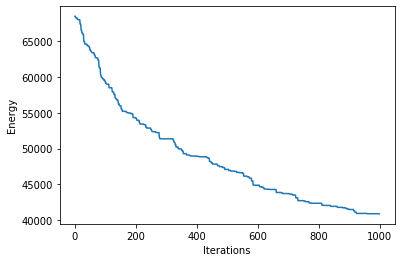


Rozkład jednostajny. Liczba elementów: 256 ; t0: 100000 liczba iteracji: 1000 Temperatura końcowa: 99001
Consecutive
Energia przed: 68708.87582649486
Energia po: 53530.22368186752


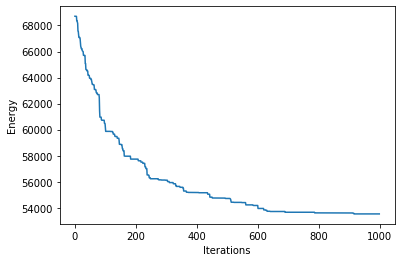


Rozkład jednostajny. Liczba elementów: 256  t0: 10000 liczba iteracji: 1000 Temperatura końcowa: 9001
Consecutive
Energia przed: 68621.20815255855
Energia po: 51725.64353953501


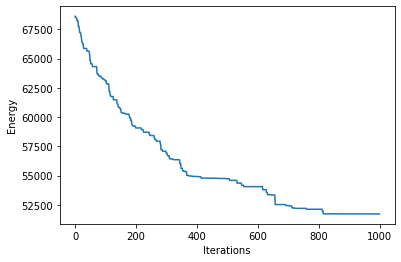

Minimal Temperature reached

Rozkład jednostajny. Liczba elementów: 256 ; t0: 1000 liczba iteracji: 1000 Temperatura końcowa: 1
Consecutive
Energia przed: 68411.71657878176
Energia po: 52546.86200587781


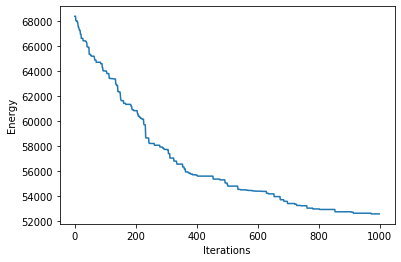

In [287]:
taskb(256)

***
### Wnioski
Pierwsze trzy z powyższych wykresów przedstawiają zależność energii od ilosći wykonanych iteracji dla opcji wyszukwiwania sąsiadów "arbitrary" - zamiana dwóch losowych wierzchołków w ścieżce. Kolejne trzy wykresy przedstawiają zalezności dla opcji "consecutive" - zamiana kolejności losowej pary połączonych wierzchołków na ścieżce. Dla każdej metody generowania sąsiadów, zostało wykoanane przybliżenie, rozpoczynając od określonej temperatury t0 = $[10^{5},10^{4},10^{3}]$, dla 245 wierzchołków wygenerowanych zgodnie z rozkładem jednolitym. Maksymalna liczba iteracji była równa 1000.<br><br>
Można zauważyć, że krzywe na pierwszych trzech wykresach osiągają niższy poziom energii, niż na trzech ostatnich wykresach (ok. 40000 do ok. 50000). Trzy ostatnie krzywe szybciej zaczynają się "wypłaszczać".Oznacza to, że losowanie "arbitrary" jest szybciej zbieżne i daje lepsze rezultaty. Jest ono zupełnie losowe i to prawdopodobnie temu faktowi zawdzięcza swoją szybszą zbieżność.<br><br>
Można również zauważyć, że wyższa temperatura początkowa powoduje wolniejszą zbieżność i wolniejsze osiąganie niskiej energii, mimo bardzo podobnej wartości początkowej energii ścieżki.

***
c) Poniżej zaimplementowana funkcja pokazuje zależność energii od liczby iteracji dla każdej metody generowania punktów.

In [307]:
def taskc(i, arr2):
    x,y = make_cities_jedn(i)
    itera = 1000
    _,_,ts,energys,k = sim_annealing(100000,0,1,0,itera,x,y,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład jednostajny. Liczba elementów:', i)
    print('Energia przed:', e)
    print('Energia po:', e1)
    print('Wykres energii od liczby iteracji' )
    y = np.arange(0,k,1)
    draw(y,energys)
    print('-----------')

    print('\n\n')
    x,y = make_cities_gauss(i)
    _,_,ts,energys,k = sim_annealing(100000,0,1,0,itera,x,y,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład Gaussa. Liczba elementów:', i)
    print('Energia przed:', e)
    print('Energia po:', e1)
    print('Wykres energii od liczby iteracji' )
    y = np.arange(0,k,1)
    draw(y,energys)
    print('-----------')

    print('\n\n')
    x,y = make_cities_nine(i,arr2)
    _,_,ts,energys,k  = sim_annealing(100000,0,1,0,itera,x,y,'arbitrary')
    e = energys[0]
    e1 = energys[len(energys)-1]

    print('\nRozkład dziewięciu odseparowanych grup. Liczba elementów:', i)
    print('Energia przed:', e)
    print('Energia po:', e1)
    print('Wykres energii od liczby iteracji' )
    y = np.arange(0,k,1)
    draw(y,energys)
    print('-----------')


Rozkład jednostajny. Liczba elementów: 256
Energia przed: 68958.03794162367
Energia po: 38557.80836686021
Wykres energii od liczby iteracji


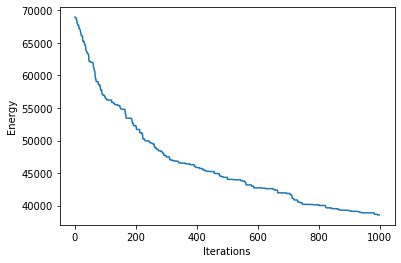

-----------




Rozkład Gaussa. Liczba elementów: 256
Energia przed: 5881.106286544369
Energia po: 2447.7657085477294
Wykres energii od liczby iteracji


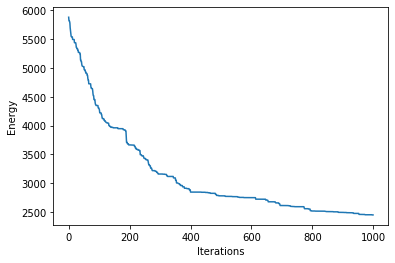

-----------




Rozkład dziewięciu odseparowanych grup. Liczba elementów: 256
Energia przed: 6657.5941452844245
Energia po: 2908.271479560024
Wykres energii od liczby iteracji


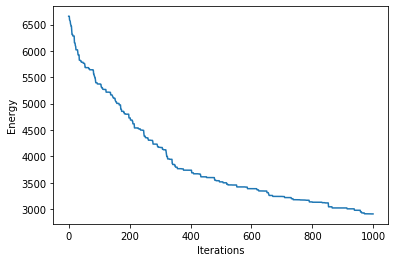

-----------


In [309]:
taskc(256, [[-10,-2],[-15,-5],[-1,1],[16,3], [5,1], [30,-1], [-25,4],[15,2],[37,5]])

***
### Wnioski
Powyższe wykresy wykonano dla maksymalnie 1000 iteracji.<br><br>
Dla każdej ścieżki, energia początkowa została znacznie zminiamalizowana w ciągu 1000 iteracji.<br><br>
Punkty dla rozkładu jednostajnego generują się z największą energią początkową. Punkty dla pozostałych dwóch rozkładów, generują się z podobną energią początkową. Jednak najmniejszą energię ma ścierzka wygenerowana przez punkty z rozkładu normalnego.<br>
Krzywe są podobnie zbieżne - najwolniej zbieżna jest krzywa dla punktów z rozkładu jednostajnego.